# (??) Fit neurons (MT)

**Motivation**: Load models, evaluate then fit MT <br>

In [1]:
# HIDE CODE


import os, sys
from IPython.display import display

# tmp & extras dir
git_dir = os.path.join(os.environ['HOME'], 'Dropbox/git')
extras_dir = os.path.join(git_dir, 'jb-MTMST/_extras')
fig_base_dir = os.path.join(git_dir, 'jb-MTMST/figs')
tmp_dir = os.path.join(git_dir, 'jb-MTMST/tmp')

# GitHub
sys.path.insert(0, os.path.join(git_dir, '_MTMST'))
from vae.train_vae import TrainerVAE, ConfigTrainVAE
from vae.vae2d import VAE, ConfigVAE
from analysis.opticflow import *
from figures.fighelper import *

# warnings, tqdm, & style
warnings.filterwarnings('ignore', category=DeprecationWarning)
from rich.jupyter import print
%matplotlib inline
set_style()

In [2]:
from torch.nn import functional as F
from sklearn.decomposition import PCA
from analysis.linear import LinearModel, flatten_stim
from base.dataset import setup_supervised_data, setup_repeat_data, time_embed

## Load neuron

In [3]:
cfg = ConfigVAE(save=False)
file = h5py.File(cfg.h_file, 'r')
expt = 'clu090'
grp = file[expt]

In [4]:
scale = 2.25
hf_kws = {
    'size': 19,
    'sres': 1,
    'radius': 6,
}
hf = HyperFlow(
    params=np.array(grp['hyperflow'])[:, 2:],
    center=np.array(grp['hyperflow'])[:, :2],
    **hf_kws,
)
stim = hf.compute_hyperflow()
spks = np.array(grp['spks'], dtype=float)
good = ~np.array(grp['badspks'])
good = np.where(good)[0]

# src, tgt = setup_supervised_data(lags, good, stim, spks)
stim_r, spks_r, intvl = setup_repeat_data(grp, lags=None, hf_kws=hf_kws)

stim_scale = np.max(np.abs(stim))
stim *= scale / stim_scale
if stim_r is not None:
    stim_r *= scale / stim_scale

stim.shape, stim_r.shape

((72000, 2, 19, 19), (36000, 2, 19, 19))

## Reservoir

In [5]:
vae = VAE(ConfigVAE(
    n_kers=4,
    n_latent_scales=2, n_groups_per_scale=20, n_latent_per_group=7,
    scale_init=False, residual_kl=True, ada_groups=True,
))
tr = TrainerVAE(model=vae, cfg=ConfigTrainVAE(batch_size=300), device='cuda')
vae.cfg.total_latents()

210

In [6]:
vae.print()
vae.scales

+--------------+------------+
| Module Name  | Num Params |
+--------------+------------+
|     VAE      |  17.0 Mil  |
|     ---      |    ---     |
|     stem     |   1.1 K    |
| pre_process  |   96.0 K   |
|  enc_tower   |  9.4 Mil   |
|     enc0     |   16.6 K   |
| enc_sampler  |  1.4 Mil   |
| dec_sampler  |  1.4 Mil   |
|    expand    |   71.0 K   |
|  dec_tower   |  4.5 Mil   |
| post_process |   40.0 K   |
|     out      |    578     |
+--------------+------------+

[8, 4]

### Extract features

In [7]:
from readout.readout import process_ftrs

kws_process = dict(
    scale=4,
    pool='max',
    act_fn='swish',
)

In [8]:
# Stim
enc = []
for i in tqdm(range(int(np.ceil(len(stim) / tr.cfg.batch_size)))):
    a = i * tr.cfg.batch_size
    b = min(a + tr.cfg.batch_size, len(stim))
    *_, ftr = tr.model_ema.xtract_ftr(
        x=tr.to(stim[a:b]), full=True)
    ftr = process_ftrs(ftr['enc'], **kws_process)
    ftr = torch.cat(list(ftr.values()), dim=1)
    enc.append(to_np(ftr))
enc = np.concatenate(enc)

enc_r = []
for i in range(int(np.ceil(1000 / tr.cfg.batch_size))):
    a = i * tr.cfg.batch_size
    b = min(a + tr.cfg.batch_size, len(stim_r))
    *_, ftr = tr.model_ema.xtract_ftr(
        x=tr.to(stim_r[a:b]), full=True)
    ftr = process_ftrs(ftr['enc'], **kws_process)
    ftr = torch.cat(list(ftr.values()), dim=1)
    enc_r.append(to_np(ftr))
enc_r = np.concatenate(enc_r)

enc.shape, enc_r.shape

100%|█████████████████████████████████████████| 240/240 [01:02<00:00,  3.83it/s]


((72000, 5312, 4, 4), (1200, 5312, 4, 4))

In [9]:
mu, sd = enc.mean(0), enc.std(0)

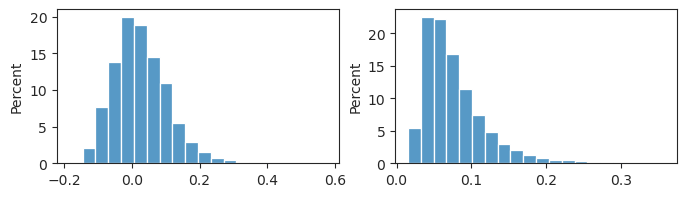

In [10]:
fig, axes = create_figure(1, 2, (8, 2))
sns.histplot(mu.ravel(), bins=20, stat='percent', ax=axes[0]);
sns.histplot(sd.ravel(), bins=20, stat='percent', ax=axes[1]);

In [11]:
mu, sd = enc.mean(), enc.std()
mu, sd

(0.026398346, 0.1213682)

In [12]:
enc = (enc - mu) / sd
enc_r = (enc_r - mu) / sd

In [13]:
pca = PCA(n_components=500)
x = pca.fit_transform(flatten_stim(enc))
x_r = pca.transform(flatten_stim(enc_r))

x.shape, x_r.shape

((72000, 500), (1200, 500))

0
{1: 49.14316710333222, 5: 53.49949415195903, 10: 54.30810076979078}

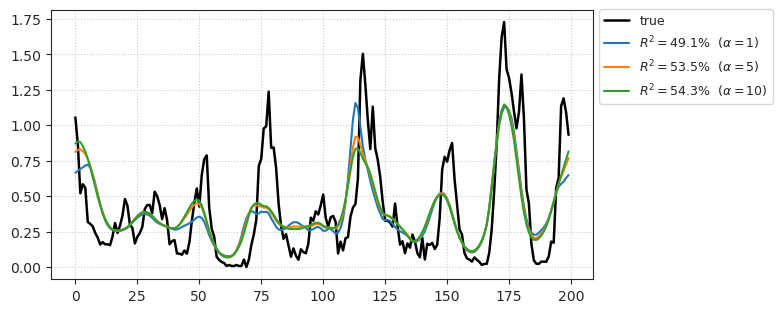

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

1
{1: 58.92715275894209, 5: 61.85784651794191, 10: 61.86052389937239}

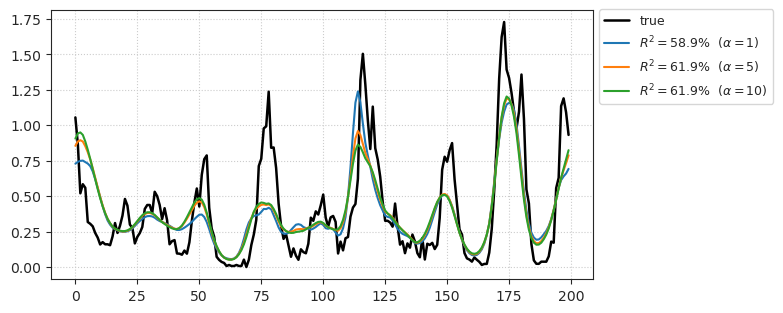

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

2
{1: 65.84871314525871, 5: 65.54957956611345, 10: 64.3196898841537}

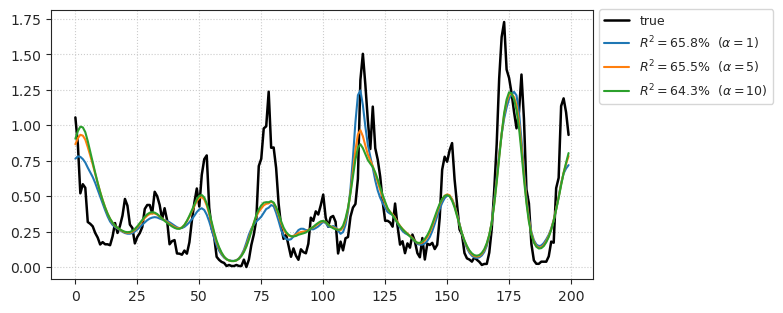

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

3
{1: 65.15457547809784, 5: 61.21575829387852, 10: 59.28284474062537}

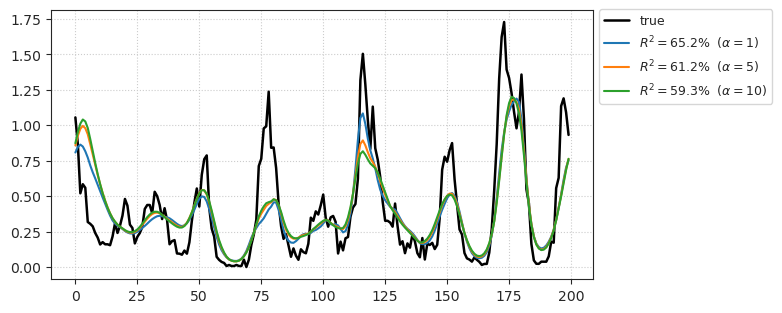

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

4
{1: 56.261017121795916, 5: 50.308459100992685, 10: 48.21527124396133}

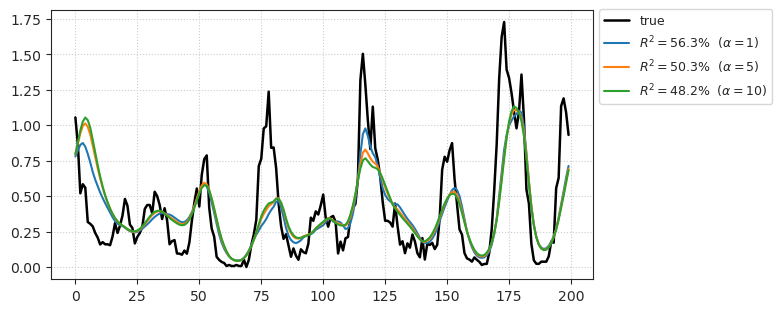

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

5
{1: 37.333363681275756, 5: 32.22879586877339, 10: 31.41842349099313}

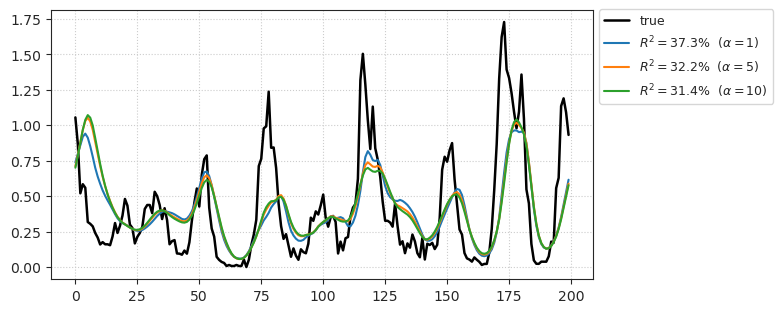

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

6
{1: 15.087291487936284, 5: 12.134504321728535, 10: 13.066519409363709}

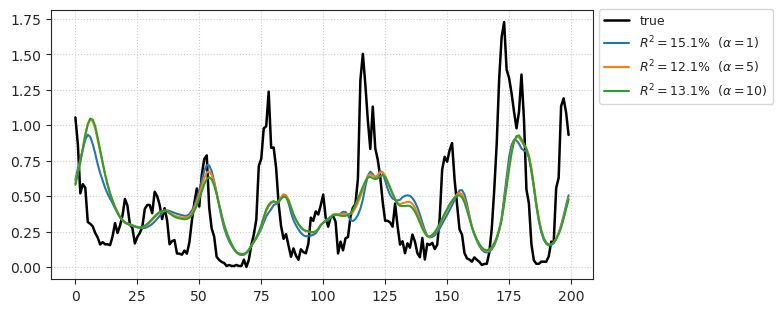

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

7
{1: -5.9118929251464225, 5: -5.7799433942577805, 10: -2.9388210522159897}

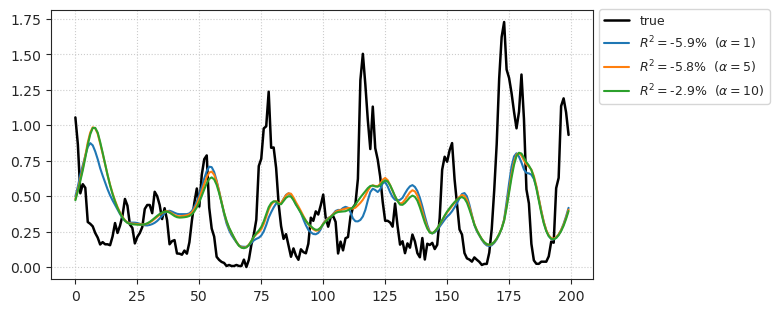

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

In [14]:
neuron_i = 0

for lag in range(8):
    idxs = good.copy()
    idxs = idxs[idxs > lag]
    
    glm_kws = dict(
        category='PoissonRegressor',
        x=x[idxs - lag],
        y=spks[idxs, neuron_i],
        x_tst=x_r[intvl - lag],
        y_tst=np.nanmean(spks_r[neuron_i], 0),
        alphas=[1, 5, 10],
    )
    glm = LinearModel(**glm_kws).fit(fit_df=False, max_iter=500)
    print(lag, glm.r2_tst)
    glm.show_pred();
    print('~' * 80)
    print('\n\n\n')

In [15]:
lags = 5
src = time_embed(x, lags=lags, idxs=good)
src_r = time_embed(x_r, lags=lags, idxs=intvl)
src.shape, src_r.shape

((54386, 5, 500), (200, 5, 500))

In [16]:
%%time

glm_kws = dict(
    category='PoissonRegressor',
    x=src,
    y=spks[good, neuron_i],
    x_tst=src_r,
    y_tst=np.nanmean(spks_r[neuron_i], 0),
    alphas=[5, 10, 15, 20],
)
glm = LinearModel(**glm_kws).fit(fit_df=False, max_iter=1000)
print(glm.r2_tst)

{5: 68.76957887548562, 10: 67.71131426454649, 15: 66.73088909654459, 20: 65.92195401670722}

CPU times: user 49min 30s, sys: 5min 31s, total: 55min 2s
Wall time: 10min 46s


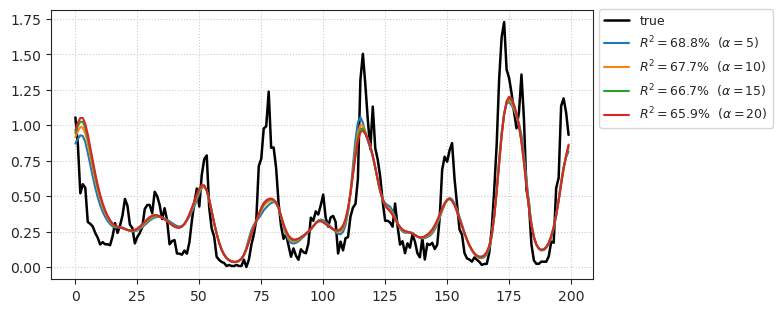

In [17]:
glm.show_pred();

## Select best pix/lag using STA

In [19]:
from analysis.linear import compute_sta

In [24]:
lags = 21
sta = compute_sta(
    lags=lags,
    good=good,
    stim=enc,
    spks=spks,
    verbose=True,
    normalize=True,
)
sta.shape

100%|████████████████████████████████████| 54384/54384 [04:47<00:00, 189.11it/s]


(1, 21, 5312, 4, 4)

In [25]:
enc.shape, spks.shape, len(good)

((72000, 5312, 4, 4), (72000, 1), 54386)

In [35]:
sta.mean(), sta.std()

(0.010635398416079177, 0.691037375734568)

In [37]:
sta.shape

(1, 21, 5312, 4, 4)

In [38]:
flatten_stim(sta[0]).shape

(21, 84992)

In [62]:
u, s, v = sp_lin.svd(flatten_stim(sta[0]), full_matrices=False)
var_explained = 100 * s / s.sum()

In [63]:
np.round(var_explained)

array([92.,  7.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])

In [64]:
u.shape, v.shape

((21, 21), (21, 84992))

In [76]:
top_temporal = sp_stats.zscore(u[:, 0])
top_space_filt = v[0].reshape(enc.shape[1:])

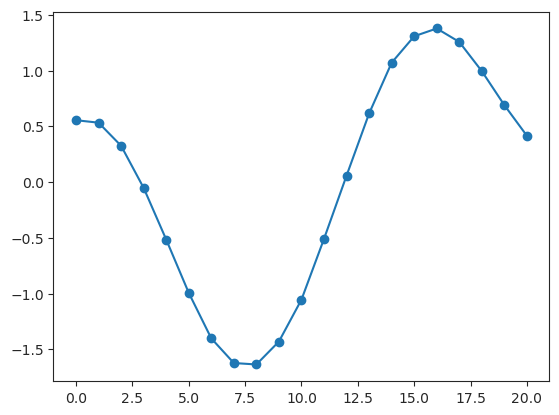

In [85]:
plt.plot(top_temporal, marker='o')

In [87]:
best_lag = np.argmax(np.abs(top_temporal)[-10:])
best_lag

5

In [68]:
flatten_stim(top_space_filt).shape

(5312, 16)

In [91]:
np.unravel_index(np.argmax(np.abs(top_space_filt)), top_space_filt.shape)

(1931, 2, 2)

In [95]:
i, j = np.unravel_index(np.argmax(np.abs(top_space_filt)[1931]), (4, 4))
i, j

(2, 2)

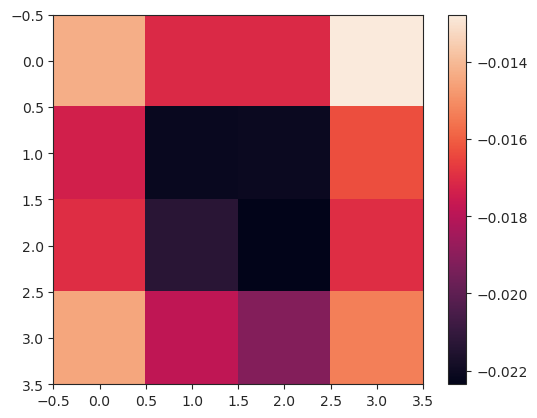

In [96]:
plt.imshow(top_space_filt[1931])
plt.colorbar()

In [ ]:
%%time

lag = 5
idxs = good.copy()
idxs = idxs[idxs > lag]

neuron_i = 0
alphas = [1e-3, 1e-2, 5e-2, 1e-1, 1, 10]
results = {
    a: np.zeros((4, 4))
    for a in alphas
}
for i, j in itertools.product(range(4), range(4)):
    glm_kws = dict(
        category='PoissonRegressor',
        x=enc[idxs - lag, ..., i, j],
        y=spks[idxs, neuron_i],
        x_tst=enc_r[intvl - lag, ..., i, j],
        y_tst=np.nanmean(spks_r[neuron_i], 0),
        alphas=alphas,
    )
    glm = LinearModel(**glm_kws).fit(fit_df=False, max_iter=500)
    for k, v in glm.r2_tst.items():
        results[k][i, j] = v if v > 0 else np.nan
    print(i, j, glm.r2_tst)

/home/hadi/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_glm/glm.py:287: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)


0 0
{
    0.001: 31.942246256199812,
    0.01: 23.647273554273028,
    0.05: 21.03130161962564,
    0.1: 20.563167551539518,
    1: 15.879795677195451,
    10: 5.625307955262471
}

/home/hadi/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_glm/glm.py:287: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)


0 1
{
    0.001: 1.8986106550277881,
    0.01: 25.47640475904074,
    0.05: 21.465422599543338,
    0.1: 15.447900354676081,
    1: 8.45648487845343,
    10: 9.869131295738121
}

/home/hadi/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_glm/glm.py:287: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)


0 2
{
    0.001: 26.81060960308528,
    0.01: 23.60760054677694,
    0.05: 33.58994543730673,
    0.1: 34.09962629611872,
    1: 24.933421147762125,
    10: 20.320017472324803
}

/home/hadi/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_glm/glm.py:287: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)


0 3
{
    0.001: 5.14679368424914,
    0.01: 32.72433521827922,
    0.05: 34.17038067184429,
    0.1: 34.644865309624606,
    1: 34.717817397319436,
    10: 19.64765313057072
}

In [ ]:
best = np.zeros((len(results), 4, 4))
for i, v in enumerate(results.values()):
    best[i] = v
best = np.nanmax(best, 0);

In [ ]:
fig, axes = create_figure(1, 6, (9, 1.3), 'all', 'all', constrained_layout=True)
for ax, (k, v) in zip(axes.flat, results.items()):
    im = ax.imshow(v, vmin=0)
    plt.colorbar(im, ax=ax)
    ax.set_title(f"a = {k}")
im = axes[-1].imshow(best)
plt.colorbar(im, ax=axes[-1])
axes[-1].set_title('best')
plt.show()